In [59]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import time
import math
import json
import random
from copy import deepcopy

from scipy.stats import norm
from collections import Counter
from collections import OrderedDict, defaultdict

import networkx as nx

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="white")

# Gaussian weights

Instead of having a separate copy of weights for each node we now have a "master_weights" matrix and each node is going to use a subset of that matrix prova prova prova

In [2]:
def node_to_idxs(node, N):
    return node // N, node % N

In [3]:
def make_master_weights(N, locality):
    rv = norm(loc=0, scale=locality)
    x = np.linspace(
        -1, 1, N * 2 + 1
    )  # size is twice as big because we are going to use NxN subsets of it
    p = rv.pdf(x)  # make marginal gaussians
    X, Y = np.meshgrid(
        p, p
    )  # use numpy magic to make them of the right shapes before combining them
    w = X * Y  # compute the 2D gaussian by multiplying the marginals together
    w /= w.sum()
    return w

Let's test this "master weights" thing to check it works

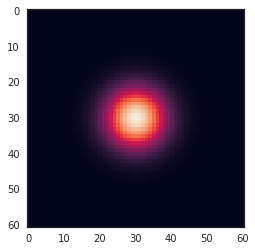

In [4]:
N = 30
locality = 0.2
W = make_master_weights(N=N, locality=locality)
plt.imshow(W)

So far so good, now let's take subsets of each for each node.
We will see the gaussian "pimple" move around as the target node changes

In [5]:
def get_subset(W, node, N):
    assert 0 <= node and node < N * N, f"Node index out of bounds: "
    i, j = node_to_idxs(node, N)  # convert node index to row,col coordinates
    subset = W[
        N - i : N - i + N, N - j : N - j + N
    ]  # extract a subset of the master_weights
    return np.copy(
        subset
    )  # make a copy to make sure subsequent manipulations don't affect the master

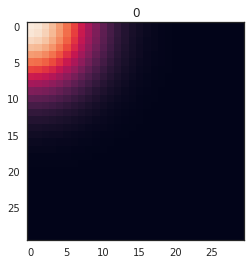

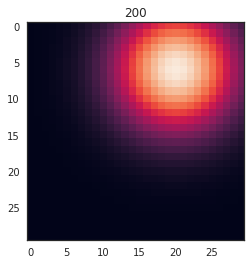

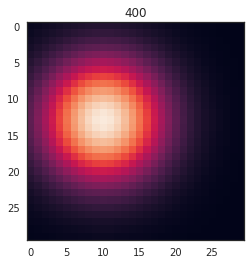

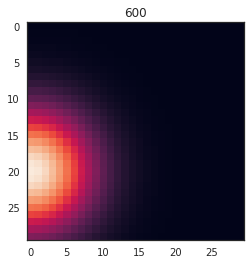

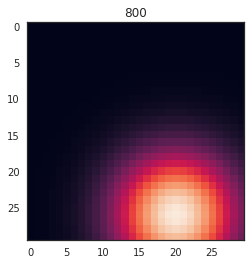

In [6]:
for node in np.arange(0, N * N, 200):
    subset = get_subset(W, node, N)
    plt.imshow(subset)
    plt.title(node)
    plt.show()

Ok, the weights look good. Before we can use them to sample from an hypothetical node we need to remove existing edges.
We are going to make dummy adjacency list to simulate this scenario.

In [7]:
def compute_gaussian_weights(W, node, adjL):
    tmp, N = W.shape
    tmp, N = (
        tmp // 2,
        N // 2,
    )  # recover side-len from the weigths matrix, yeah, I did't want to have an extra parameter going around
    assert tmp == N, f"Weights have not the expected shape: Expected (,), got (,)"
    gauss = get_subset(
        W, node, N
    )  # get the appropiate subset in the manner we have shown above
    i, j = node_to_idxs(node, N)  # zero the node coords to avoid self loops
    gauss[i][j] = 0
    for neigh in adjL[node]:  # go through the neighs in the adjlist and zero them
        i, j = node_to_idxs(neigh, N)
        gauss[i][j] = 0
    gauss = (
        gauss / gauss.sum()
    )  # normalize everything to make sure we have probabilities
    return gauss.flatten()  # flatten them to use with np.random.choice

In [8]:
node = 43
dummy_adjL = {
    43: set([2, 45, 39, 70, 100, 250])
}  # edge 43 is connected to some random nodes
dummy_adjL

{43: {2, 39, 45, 70, 100, 250}}

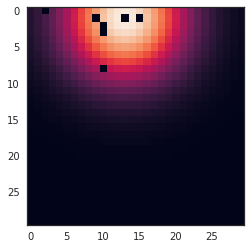

In [9]:
weights = compute_gaussian_weights(W, node, dummy_adjL)
plt.imshow(weights.reshape((N, N)))  # notice the black dots where edges exist already

# Sampling

We are now ready to use the weights to sample new edges

In [11]:
# Let's redefine our paramters to have everything in one place
N = 30
node = N * (N - 1) // 2  # pick a node in the center
locality = 0.2
W = make_master_weights(N=N, locality=locality)
dummy_adjL = {
    node: set([node - 2 * N, node + 2 * N, node + 2, node - 2])
}  # add edges in a cross pattern
weights = compute_gaussian_weights(W, node, dummy_adjL)
num_points = N ** 2
nodes = np.arange(N * N)

Test single samples, we should see a noisy gaussian structure

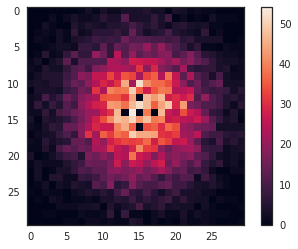

In [12]:
nodes = np.arange(N * N)
samples = [
    np.random.choice(nodes, p=weights, replace=False, size=1)[0] for _ in range(10000)
]

# How many times each node has been picked?
samples = Counter(samples).most_common()

results = np.zeros((N, N))
for coord, count in samples:
    # turn nodes id into coordinates for plotting
    x, y = coord // N, coord % N
    results[x][y] = count
plt.imshow(results)
plt.colorbar()

We can see that patern of empty dots around the center node we are sampling from. The method seems to work.

# Communicating agents

## Utils

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

def make_communities(community_side, communities_per_side):
    """
    Compute indexes for communities on a lattice
    e.g.

    A A A B B B
    A A A B B B
    A A A B B B
    C C C D D D
    C C C D D D
    C C C D D D

    community_side       = 3
    community_size       = 3*3 = 9
    communities_per_side = 2
    num_communities      = 4
    tot nodes            = 4*9

    returns:    [
                    [0,1,2,6,7,8,12,13,14] -> A
                    [3,4,5,9,10,11,,15,16,17] -> B
                    ...
                ]

    Paramteres:
        :int community_side:            The side len of each community
        :int communities_per_side:      The number of communites on each side

    Returns:
        List of lists of nodes for each community (see Example above)
    """
    community_size = community_side * community_side
    communities = []
    seed_node = 0
    for i in range(communities_per_side):
        for j in range(communities_per_side):
            community = []
            for k in range(community_side):
                for z in range(community_side):
                    _id = (
                        communities_per_side * community_size * i
                        + community_side * j
                        + z
                        + k * (communities_per_side * community_side)
                    )
                    # print(f"{_id} ", end="")
                    community.append(_id)
                # print("- ", end="")
            communities.append(community)
            #print()
    return communities

def make_layout(side_len):
    points = side_len ** 2
    x, y = np.meshgrid(np.arange(side_len), np.arange(side_len))  # make grid
    x, y = x.reshape(points), y.reshape(points)  # flatten to turn into pairs
    layout = {
        (points - 1 - idx): coords for idx, coords in enumerate(zip(reversed(x), y))
    }  # assign x,y to each node idx
    # points -1 and reverserd are used to match row/cols matrix format
    return layout

## Network and Nodes

In [479]:
class Network:
    def __init__(self, comm_side, comms_per_side, locality, threshold):
        # REMEMBER WE ARE USING A 2D LATTICE
        # side length of each community
        self.comm_side = comm_side
        # number of nodes per community
        self.comm_size = self.comm_side * self.comm_side
        # number of communities per side
        self.comms_per_side = comms_per_side
        # number of nodes per side of the network
        self.N = self.comm_side * self.comms_per_side
        # total number of nodes in the network
        self.numNodes = self.N * self.N
        # list of lists of node IDs for each community
        self.communityIDs = make_communities(self.comm_side, self.comms_per_side)
        self.locality = locality
        # the master weights used to compute the gaussian weioght sampling
        self.W = make_master_weights(self.N, self.locality)
        # list of nodes IDS i.e. [0,1,2,3,...,N*N]
        self.nodeIDs = np.arange(self.numNodes)
        self.threshold=threshold
        
        # TO BE INITIALIZED
        # list of the actual Nodes
        self.nodes = []
        # list of list of Nodes in each community
        self.communities = []
        self.adjL = {}
        
        self.activity_history = []
        self.spiking_history = []
        self.current_activity = []
        self.current_spiking = []
    
    def initialize(self,numEdges):
        self.nodes = [Node(ID, self) for ID in self.nodeIDs]
        self.communities = [[self.nodes[idx] for idx in ids] for ids in self.communityIDs]
        self.adjL = {node:set() for node in self.nodeIDs}
        for _fromID in range(self.numNodes):
            weights = compute_gaussian_weights(self.W, _fromID, self.adjL)
            samples = np.random.choice(self.nodeIDs, p=weights, replace=False, size=numEdges)
            for _toID in samples:
                _from = self.nodes[_fromID]
                _to = self.nodes[_toID]
                self.adjL[_fromID].add(_toID)
                _from._out.append(_to)
                _to._in.append(_from)
        self.current_activity = np.zeros((self.N,self.N))
        self.current_spiking = np.zeros((self.N,self.N))
                
    def to_networkx(self):
        edges = {node:list(edges) for node,edges in self.adjL.items()}
        return nx.DiGraph(edges)
    
    def show(self):
        g = self.to_networkx()
        layout = make_layout(self.N)
        plt.figure(figsize=(16, 16))
        nx.draw(g, with_labels=False, pos=layout, node_size=80)
        
    def inspect(self):
        fig, axs = plt.subplots(1, 2, figsize=(8, 4))
        
        activity = axs[0].imshow(self.activity_history[-1])
        axs[0].set_xticks([])
        axs[0].set_yticks([])
        # xgrid, ygrid = np.meshgrid(ticks, ticks)
        # axs[0].scatter(xgrid,ygrid, alpha=0.4)
        
        divider = make_axes_locatable(axs[0])
        cax = divider.append_axes("right", size="5%", pad=0.05)
        fig.colorbar(activity, cax=cax)
        
        axs[1].imshow(self.spiking_history[-1])
        axs[1].set_xticks([])
        axs[1].set_yticks([])
        plt.tight_layout(h_pad=1)
        plt.show()
        
    def spark(self):
        community = random.choice(net.communities)
        [node.spark() for node in community]
    
    def check(self):
        [node.check() for node in self.nodes]
        
    def update(self):
        [node.update() for node in self.nodes]
        self.activity_history.append(self.current_activity)
        self.spiking_history.append(self.current_spiking)
        self.current_activity = np.zeros((self.N,self.N))
        self.current_spiking = np.zeros((self.N,self.N))
    
    def dead(self):
        return self.spiking_history[-1].sum() == 0
    
class Node:
    def __init__(self, ID, network):
        self.id = ID
        self.N = network.N
        self.coords = node_to_idxs(self.id, self.N)
        self.info = {}
        self.threshold = network.threshold
        self.activity = 0
        self._out = []
        self._in = []
        self.spiking = False
        self.network = network
        
    def excite(self):
        self.network.current_activity[self.coords] += 1
        self.activity += 1
    
    def spark(self):
        self.spiking = True
        self.activity = self.threshold
    
    def check(self):
        if self.activity >= self.threshold:
            self.spiking = True
            self.network.current_spiking[self.coords] = 1
        self.activity = 0
            
    def update(self):
        if self.spiking:
            [neigh.excite() for neigh in self._out]
        self.spiking = False
        
    def __repr__(self):
        return f"ID: {self.id}"

## Testing

In [485]:
comm_side = 5
comms_per_side=5
threshold = int(comm_side*(comm_side - 1)/2)
wires = comm_side*(comm_side - 1)
net = Network(comm_side=comm_side,comms_per_side=comms_per_side,locality=0.1, threshold=threshold)
print(f"wires {wires}, threshold {threshold}")

wires 20, threshold 10


In [486]:
net.initialize(wires)

In [487]:
net.spark()

0


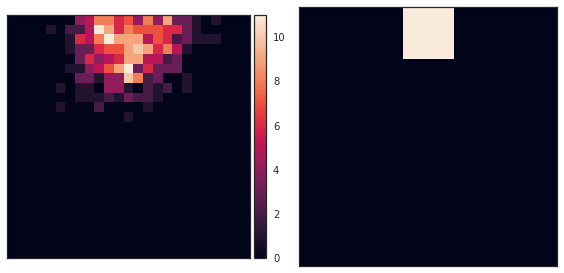

1


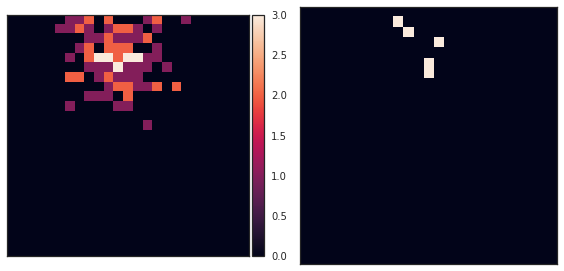

2


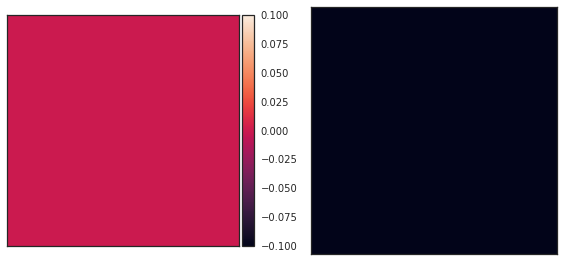

DEAD


In [488]:
for i in range(10):
    print(i)
    net.check()
    net.update()
    net.inspect()
    if(net.dead()):
        print("DEAD")
        break

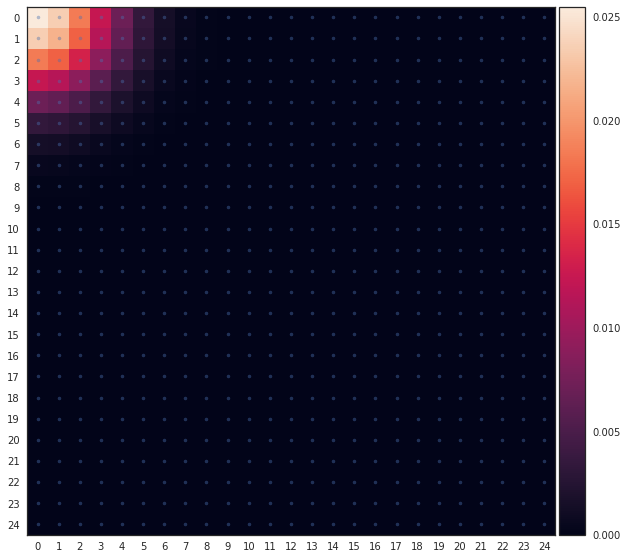

In [496]:
subset = get_subset(net.W, 0, net.N)

fig,ax = plt.subplots(figsize=(10,10))

activity = plt.imshow(subset)

ticks = list(range(net.N))
plt.xticks(ticks)
plt.yticks(ticks)
xgrid, ygrid = np.meshgrid(ticks, ticks)
plt.scatter(xgrid,ygrid, s=10,alpha=0.4)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(activity, cax=cax)

plt.show()

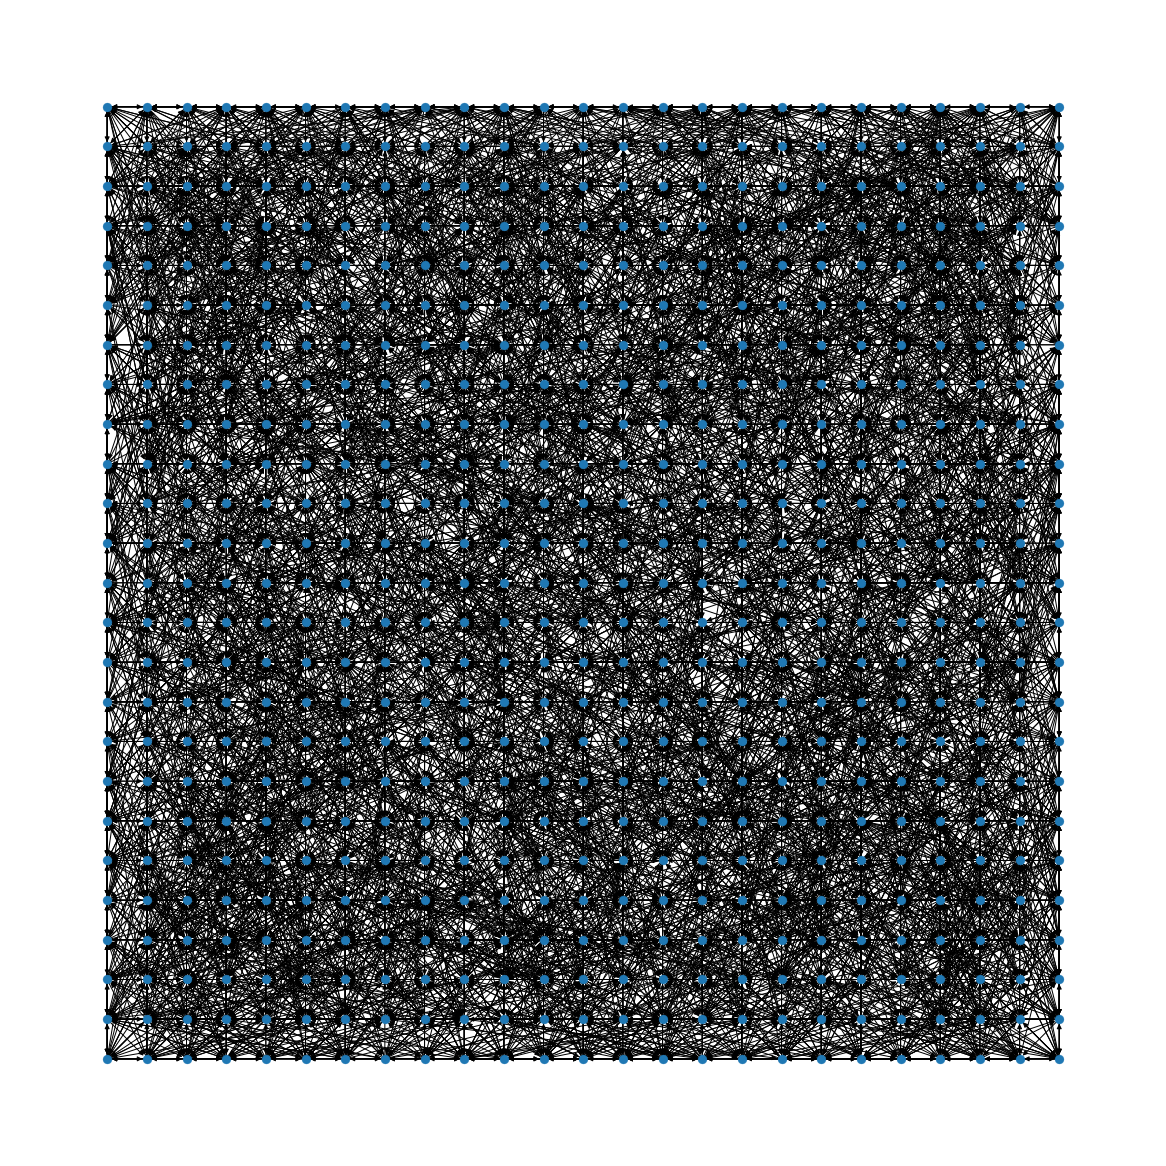

In [490]:
net.show()